In [5]:
# 1DCNN for Parkinsons anomaly detection
import os
import keras
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import streamlit as st
import random

import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

from tensorflow.keras import layers, losses, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from aeon.transformations.collection.convolution_based import Rocket
from aeon.classification.convolution_based import Arsenal, RocketClassifier

# Datensatz unter: https://physionet.org/content/gaitpdb/1.0.0/

In [6]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


def load_and_sync_data(folder_path, label, event_col=0, event_threshold=0.5, max_length=1000):
    """
    Lädt Daten, synchronisiert sie auf ein Event (z.B. Fußaufsatz) und trimmt sie auf gleiche Länge.
    
    Args:
        folder_path: Pfad zum Ordner mit den TSV-Dateien
        label: Label für die Daten (0 für Control, 1 für PD)
        event_col: Index der Spalte mit dem Event-Signal (z.B. Fersendruck)
        event_threshold: Schwellenwert für die Event-Erkennung
        max_length: Maximale Länge der Zeitreihen nach dem Trimmen
    Returns:
        X: np.array der Form (num_samples, num_features, max_length)
        y: np.array der Labels
    """
    all_data = []
    tsv_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
    
    for file_name in tsv_files:
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path, sep='\t', header=None)
        features = df.iloc[:, 1:19].values.T  # Shape: (18, num_timesteps)
        
        # 1. Synchronisation: Finde den ersten Event-Zeitpunkt
        event_idx = np.argmax(features[event_col] < event_threshold)
        
        # 2. Schneide die Daten ab diesem Zeitpunkt
        synced_features = features[:, event_idx:]
        
        # 3. Trimmen auf max_length (falls nötig)
        if synced_features.shape[1] > max_length:
            synced_features = synced_features[:, :max_length]
        all_data.append(synced_features)
    
    # 4. Finde die kürzeste Länge nach Synchronisation
    min_length = min([sample.shape[1] for sample in all_data])
    
    # 5. Trimme ALLE Daten auf diese Länge (für gleiche Dimensionen)
    X = np.array([sample[:, :min_length] for sample in all_data])
    y = np.repeat(label, len(all_data))
    
    return X, y

# --- Anwendung ---
# Lade und synchronisiere Control-Daten
X_CT, y_CT = load_and_sync_data(
    folder_path="./gait-in-parkinsons-disease-1.0.0/Control",
    label=1,
    event_col=0,  # Annahme: Spalte 0 enthält Fersendruck
    event_threshold=0.5
)

# Lade und synchronisiere PD-Daten
X_PD, y_PD = load_and_sync_data(
    folder_path="./gait-in-parkinsons-disease-1.0.0/Pt",
    label=0,
    event_col=0,
    event_threshold=0.5
)

# Kombiniere Daten
labels = np.concatenate((y_CT,y_PD), axis=0)
data = np.concatenate((X_CT,X_PD))

print(len(labels))

279


In [7]:
# first split for train and test data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

# Splitting the trainsplit again to carve validation data
# train_data, val_data, train_labels, val_labels = train_test_split(train_val_data, train_val_labels, test_size=0.2, random_state=21)

# merging testplit together with Parkinsons-split to get a diverse testsplit
test_data = np.concatenate((test_data, np.array(X_PD)), axis=0)
test_labels =  np.concatenate((test_labels, np.array(y_PD)), axis=0)


# Min/Max Normilizer auf allen Datensätzen
whole_datset = np.concatenate((X_PD, X_CT), axis= 0)
min_val = tf.reduce_min(whole_datset)
max_val = tf.reduce_max(whole_datset)
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)
# val_data = (val_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)
#val_data = tf.cast(val_data, tf.float32)

# Verändert die 0/1 Zuweisung der Probanden in eine False/True Zuweisung
train_labels = train_labels.astype(bool) 
test_labels = test_labels.astype(bool)
# val_labels = val_labels.astype(bool)

In [8]:
# from sktime.classification.kernel_based import RocketClassifier
# from sktime.datasets import load_unit_test

X_train, y_train = np.asarray(train_data, dtype= np.float32), np.asarray(train_labels, dtype= np.float32)
X_test, y_test = np.asarray(test_data, dtype= np.float32), np.asarray(test_labels, dtype= np.float32)
#X_val, y_val = np.asarray(val_data, dtype= np.float32), np.asarray(val_labels, dtype= np.float32)
trf = RocketClassifier(n_kernels= 20000, random_state = 42)

#trf = Rocket(n_kernels=30, n_jobs =-1, random_state = 42)
trf.fit(X_train, y_train)

RocketClassifier(n_kernels=20000, random_state=42)

In [9]:
trf.get_fitted_params(deep=True)

{'classes_': array([0., 1.], dtype=float32),
 'metadata_': {'multivariate': True,
  'missing_values': False,
  'unequal_length': False,
  'n_cases': 223,
  'n_channels': 18,
  'n_timepoints': 1000},
 'n_classes_': 2,
 'pipeline___classes_': array([0., 1.], dtype=float32),
 'pipeline_': Pipeline(steps=[('rocket', Rocket(n_kernels=20000, random_state=42)),
                 ('standardscaler', StandardScaler(with_mean=False)),
                 ('ridgeclassifiercv',
                  RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
        4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
        2.15443469e+02, 1.00000000e+03])))])}

In [10]:
'''

model = Sequential()

# Layer 1
model.add(layers.InputLayer(shape = (18, 1000)))
model.add(Conv1D(128, kernel_size=2, activation='relu', padding='same'))
#model.add(BatchNormalization)

# Layer
model.add(layers.Conv1D(32, 2, activation='relu'))

# Layer 3
model.add(layers.Conv1D(16, 2, activation='relu'))

model.add(layers.Dropout(0.01))


model.add(layers.GlobalAveragePooling1D())
model.add(Dense(1, activation='hard_sigmoid')) # sigmoid

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, train_labels, validation_data=(X_val, val_labels),  epochs=150, batch_size=16) 

'''


"\n\nmodel = Sequential()\n\n# Layer 1\nmodel.add(layers.InputLayer(shape = (18, 1000)))\nmodel.add(Conv1D(128, kernel_size=2, activation='relu', padding='same'))\n#model.add(BatchNormalization)\n\n# Layer\nmodel.add(layers.Conv1D(32, 2, activation='relu'))\n\n# Layer 3\nmodel.add(layers.Conv1D(16, 2, activation='relu'))\n\nmodel.add(layers.Dropout(0.01))\n\n\nmodel.add(layers.GlobalAveragePooling1D())\nmodel.add(Dense(1, activation='hard_sigmoid')) # sigmoid\n\nmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])\nmodel.summary()\n\nhistory = model.fit(X_train, train_labels, validation_data=(X_val, val_labels),  epochs=150, batch_size=16) \n\n"

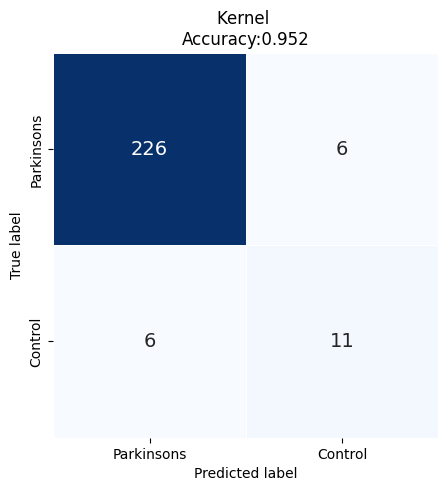

In [11]:
#y_pred = model.predict(X_test)
#y_test = test_labels

y_pred = trf.predict(X_test)
accuracy_score(y_test, y_pred)

y_pred = y_pred.astype(bool)
y_test = y_test.astype(bool)

# Creates a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index   = ['Parkinsons', 'Control'], 
                     columns = ['Parkinsons', 'Control'])

plt.figure(figsize=(5,5))
sns.heatmap(cm_df, annot=True, fmt="d", linewidths=0.5, cmap='Blues', cbar=False, annot_kws={'size':14}, square=True)
plt.title('Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [12]:
# Permutating entire feature channels
n_features = X_train.shape[1]  #amount of features (18)
feature_importance = np.zeros(n_features)

for feature_idx in range(n_features):
    # Make a copy of the test data
    X_test_permuted = X_test.copy()
    
    # Permute the selected feature across all time steps
    X_test_permuted[:, feature_idx, :] = np.random.permutation(X_test_permuted[:, feature_idx, :])
    
    # Get score difference
    original_score = trf.score(X_test, y_test)
    permuted_score = trf.score(X_test_permuted, y_test)
    feature_importance[feature_idx] = original_score - permuted_score

In [13]:
# Sort and display

sorted_indices = np.argsort(feature_importance)[::-1]

sorted_indices += 1 # get rid of 0 indexing, starting with sensor 1

for idx in sorted_indices:
    print(f"Feature {idx}: Importance = {feature_importance[idx]:.4f}")
 
# Plot
plt.figure(figsize=(12, 1))
plt.bar(range(n_features), feature_importance[sorted_indices])
plt.xticks(range(n_features), sorted_indices)
plt.xlabel("Feature Index")
plt.ylabel("Importance (Accuracy Drop)")
plt.title("Channel-wise Feature Importance for Parkinson's Detection")
plt.show()

Feature 3: Importance = -0.0120
Feature 15: Importance = -0.0040
Feature 14: Importance = 0.0040
Feature 9: Importance = -0.0080
Feature 2: Importance = 0.0080
Feature 11: Importance = -0.0120
Feature 7: Importance = -0.0080
Feature 5: Importance = -0.0201
Feature 1: Importance = 0.0000
Feature 13: Importance = 0.0040
Feature 16: Importance = -0.0080
Feature 17: Importance = -0.0080
Feature 8: Importance = 0.0000
Feature 10: Importance = 0.0000


IndexError: index 18 is out of bounds for axis 0 with size 18

In [ ]:
# Get predictions from the model
y_pred = trf.predict(X_test)

# Find indices of correctly and incorrectly classified samples
correct_indices = np.where(y_pred == y_test)[0]
incorrect_indices = np.where(y_pred != y_test)[0]

print(" Correct indices ")
print(correct_indices)
print("\n Incorect indices")
print(incorrect_indices)
print("True labels")
print(test_labels[incorrect_indices])
print("Predicted labels")
print(y_pred[incorrect_indices])

 Correct indices 
[  0   1   3   4   5   6   7   8   9  10  11  12  13  14  16  18  19  20
  21  22  24  26  27  28  29  30  32  33  34  35  36  37  38  39  40  41
  42  43  44  45  46  47  48  49  50  54  55  56  57  58  59  60  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 234 235 236 237 238 239 241 242 243 244 245
 246 247 248]

 Incorect indices
